## Welcome to the pipeline of my zillow project

In [131]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

import aquire
import prep
import split_scale
import model
import features

from jupyterthemes import jtplot
import warnings
warnings.filterwarnings("ignore")

### Aquire

In [142]:
query = """
    SELECT 
        bathroomcnt as bathrooms,
        bedroomcnt as bedrooms, 
        calculatedfinishedsquarefeet as squarefeet, 
        fireplacecnt as fireplace,
        garagecarcnt as garage,
        hashottuborspa as hottub,
        lotsizesquarefeet as lotsize,
        poolcnt as pool,
        fips as counties,
        taxvaluedollarcnt as taxvalue
        FROM properties_2017
        JOIN predictions_2017 USING (parcelid)
        WHERE transactiondate BETWEEN "2017-05-01" AND "2017-06-31"
            AND propertylandusetypeid in ("261")
            AND calculatedfinishedsquarefeet is not null
            AND lotsizesquarefeet is not null
            AND NOT (finishedsquarefeet50 is not null AND finishedsquarefeet50 > calculatedfinishedsquarefeet)
"""

In [143]:
df = aquire.get_data(query,"zillow")

In [144]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14906 entries, 0 to 14905
Data columns (total 10 columns):
bathrooms     14906 non-null float64
bedrooms      14906 non-null float64
squarefeet    14906 non-null float64
fireplace     2115 non-null float64
garage        5253 non-null float64
hottub        476 non-null float64
lotsize       14906 non-null float64
pool          3272 non-null float64
counties      14906 non-null float64
taxvalue      14906 non-null float64
dtypes: float64(10)
memory usage: 1.1 MB


,bathrooms,bedrooms,squarefeet,fireplace,garage,hottub,lotsize,pool,counties,taxvalue
0,2.0,3.0,1458.0,NaN,NaN,NaN,8284.0,1.0,6037.0,136104.0
1,1.0,2.0,1421.0,NaN,NaN,NaN,6707.0,NaN,6037.0,35606.0
2,3.0,4.0,2541.0,NaN,2.0,NaN,4975.0,NaN,6059.0,880456.0
3,2.0,3.0,1650.0,NaN,NaN,NaN,7300.0,NaN,6037.0,614000.0
4,1.0,2.0,693.0,NaN,NaN,NaN,2908.0,NaN,6037.0,274237.0


### Prep

In [145]:
df = df.replace(np.nan, "0")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14906 entries, 0 to 14905
Data columns (total 10 columns):
bathrooms     14906 non-null float64
bedrooms      14906 non-null float64
squarefeet    14906 non-null float64
fireplace     14906 non-null object
garage        14906 non-null object
hottub        14906 non-null object
lotsize       14906 non-null float64
pool          14906 non-null object
counties      14906 non-null float64
taxvalue      14906 non-null float64
dtypes: float64(6), object(4)
memory usage: 1.1+ MB


In [146]:
# df = prep.remove_zeros(df).dropna()

In [147]:
data_dict = {
    "bathroomcnt":"hi", 
    "bedroomcnt":"hello",
    "calculatedfinishedsquarefeet":"calculatedsqft had the least nulls. "
                                    "finishedsquarefeet6/12/13 all equaled calculated, so they were ignorable. "
                                    "for all finishedsquarefeet50 that were less than calculated, "
                                    "those values equaled the completedfirstfloor, therefore ignored. "
                                    "for all finishedsquarefeet50 that were greater than calculated, "
                                    "there were only six, and the anomaly was unknown, so they were removed",
    "taxvaluedollarcnt":"more"
}

### Split & Scale

In [148]:
#a random state of 123 is set to the default in the split function
train, test = split_scale.split_my_data(df, .80)

In [149]:
X_train = train.drop(columns="taxvalue")
X_test = test.drop(columns="taxvalue")
y_train = train[["taxvalue"]]
y_test = test[["taxvalue"]]

In [150]:
X_train_scaled, X_test_scaled, scaler = split_scale.standard_scaler(X_train, X_test)
# X_train_scaled, X_test_scaled, scaler = split_scale.min_max_scaler(X_train, X_test)

### Explore

In [151]:
# sns.pairplot(train, palette ="blues")

In [152]:
train.head()

,bathrooms,bedrooms,squarefeet,fireplace,garage,hottub,lotsize,pool,counties,taxvalue
9563,2.0,3.0,1120.0,0,0,0,2852.0,0,6037.0,163556.0
4532,1.0,3.0,935.0,0,0,0,2494.0,0,6037.0,642308.0
2280,3.0,2.0,2274.0,0,0,0,11799.0,1,6037.0,681990.0
12536,3.0,4.0,2818.0,0,2,0,7280.0,1,6059.0,847791.0
5733,1.0,2.0,1176.0,0,0,0,72360.0,0,6037.0,1054771.0


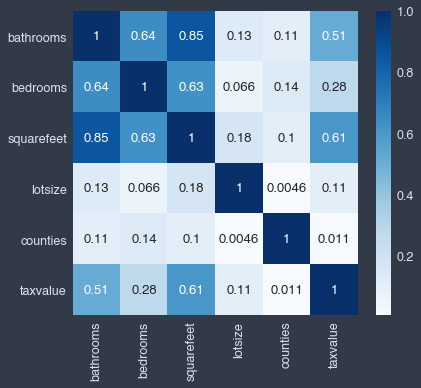

In [164]:
sns.heatmap(train.corr(), cmap='Blues', annot=True)

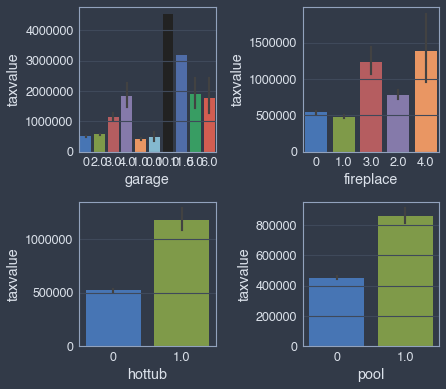

In [154]:
plt.subplot(221)
sns.barplot(x="garage",y="taxvalue", data=train) 
plt.subplot(222)
sns.barplot(x="fireplace",y="taxvalue", data=train) 
plt.subplot(223)
sns.barplot(x="hottub",y="taxvalue", data=train) 
plt.subplot(224)
sns.barplot(x="pool",y="taxvalue", data=train) 
plt.tight_layout()
plt.show()


### Feature Selection

In [155]:
features.select_kbest_freg(X_train_scaled, y_train, 4)

['bathrooms', 'bedrooms', 'squarefeet', 'pool']

In [156]:
features.ols_backware_elimination(X_train_scaled, y_train)

['bathrooms', 'bedrooms', 'squarefeet', 'fireplace']

(bathrooms      53627.915396
 bedrooms     -127420.855342
 squarefeet    491336.652941
 fireplace     -33131.782940
 garage        -16657.139358
 hottub          3384.901005
 lotsize            0.000000
 pool            4708.973054
 dtype: float64, <matplotlib.axes._subplots.AxesSubplot at 0x1c2e9a8128>)

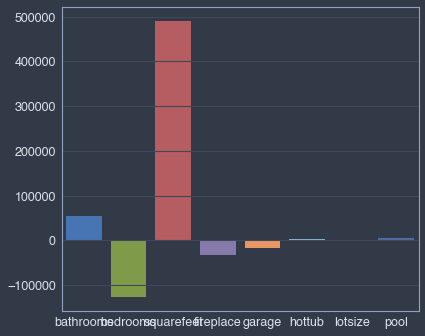

In [94]:
features.lasso_cv_coef(X_train_scaled, y_train)

In [157]:
features.recursive_feature_elimination(X_train, y_train)

Index(['bathrooms', 'bedrooms', 'squarefeet', 'fireplace', 'garage', 'hottub',
       'lotsize', 'pool', 'counties'],
      dtype='object')

### Modeling & Evaluation

In [158]:
baseline = model.compute_baseline(y_train)

In [159]:
predictions = y_train.rename(columns = {"taxvalue":"actuals"})
predictions = model.linear_model(X_train_scaled, y_train, predictions).round(0)

In [160]:
model.evaluate(predictions.actuals, predictions.lm)

(348822495903.5453, 4159359441153874.0, 590611.967287783, 0.3905057228085791)

In [161]:
model.evaluate(predictions.actuals, baseline)

(572314636834.5511, 6824279729615188.0, 756514.7961768832, 0.0)

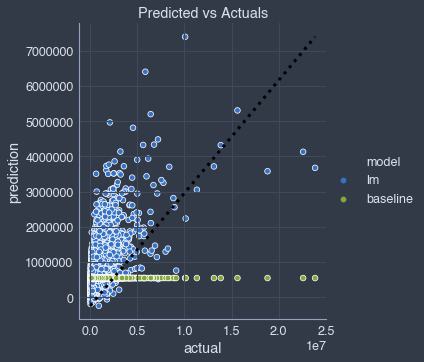

In [162]:
model.plot_linear_model(predictions.actuals,predictions.lm, baseline)
jtplot.style()

plt.plot([predictions.actuals.min(), predictions.actuals.max()], [predictions.lm.min(), predictions.lm.max()],
         c='black', ls=':', linewidth = 3)
plt.title('Predicted vs Actuals')
plt.show()